### **Tech Challenge 1 - Machine Learning**

Este projeto visa desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde, utilizando o [dataset "US Health Insurance" do Kaggle](https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset/data).

#### **1. Carregamento dos Dados**

Iniciamos o projeto importando as bibliotecas essenciais e carregando nosso conjunto de dados.

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

try:
    df_insurance = pd.read_csv('insurance.csv')
    print("Arquivo 'insurance.csv' carregado com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivo 'insurance.csv' não encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

Arquivo 'insurance.csv' carregado com sucesso.


---

#### **2. Exploração de Dados (EDA)**

Nesta etapa, vamos investigar a estrutura, os tipos de dados e as distribuições para entender profundamente as características do nosso dataset.

In [171]:
# Avaliando o formato do arquivo (linhas, colunas)
print(f"Shape do DataFrame: {df_insurance.shape}")

# Verificando tipos de dados e valores nulos
print("\nInformações do DataFrame:")
df_insurance.info()

Shape do DataFrame: (1338, 7)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Ótimo, a base não contém valores nulos, o que simplifica a etapa de limpeza.

**Descrição das Colunas:**
* **age**: Idade do beneficiário principal.
* **sex**: Gênero do contratante do seguro ('male', 'female').
* **bmi**: Índice de Massa Corporal (IMC).
* **children**: Número de dependentes.
* **smoker**: Se a pessoa é fumante ('yes', 'no').
* **region**: Região de residência do beneficiário nos EUA.
* **charges**: (Nossa variável alvo) Custos médicos individuais.

In [172]:
# Visualizando as 5 primeiras e últimas linhas
print("\nPrimeiras 5 linhas:")
display(df_insurance.head())

print("\nÚltimas 5 linhas:")
display(df_insurance.tail())

# Verificando a quantidade de valores únicos por coluna
print("\nValores únicos por coluna:")
display(df_insurance.nunique())


Primeiras 5 linhas:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



Últimas 5 linhas:


,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603



Valores únicos por coluna:


age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

Agora, vamos analisar a distribuição das variáveis numéricas e categóricas.

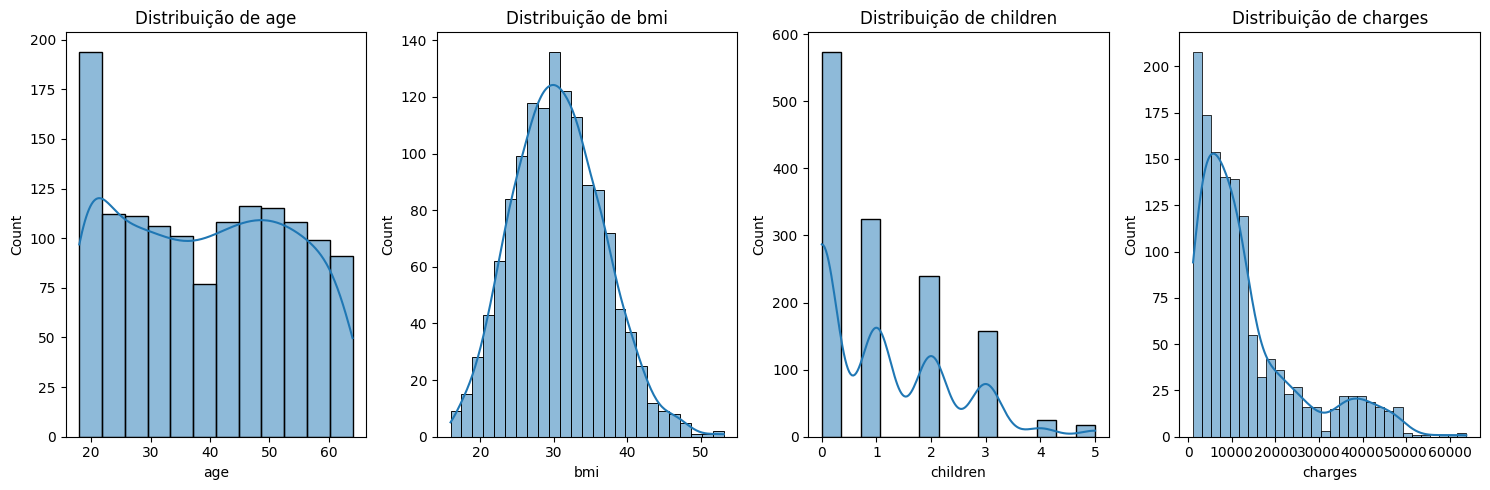

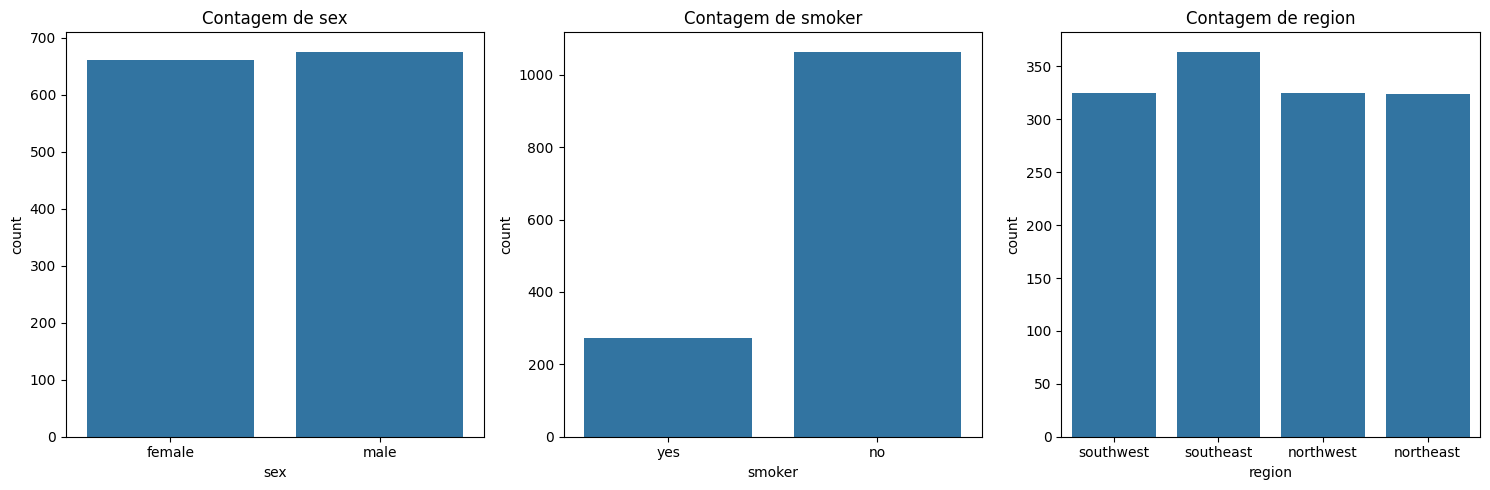

In [173]:
numerical_cols = df_insurance.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_insurance.select_dtypes(include=['object']).columns

# Plotando histogramas para variáveis numéricas
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.histplot(df_insurance[col], kde=True)
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

# Plotando gráficos de contagem para variáveis categóricas
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i + 1)
    sns.countplot(data=df_insurance, x=col)
    plt.title(f'Contagem de {col}')
plt.tight_layout()
plt.show()

##### **Análise de Correlação**

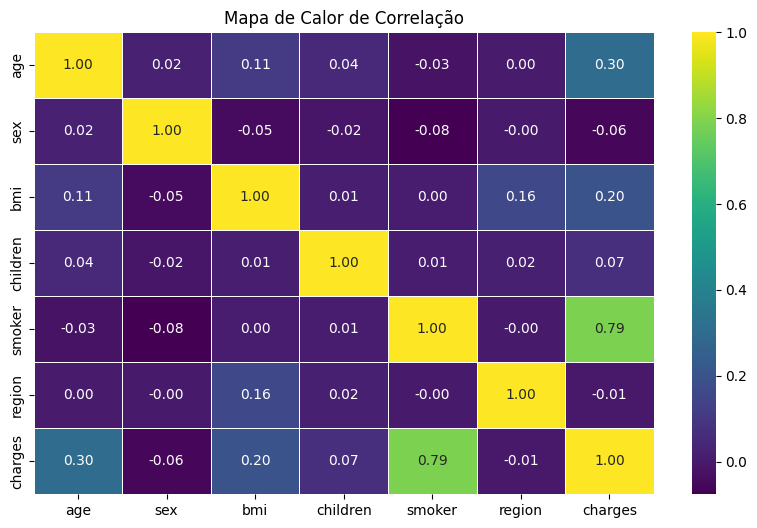

In [174]:
# Criando uma cópia para a análise de correlação
df_corr = df_insurance.copy()

# Mapeamento manual para análise exploratória
df_corr['sex'] = df_corr['sex'].map({'male': 0, 'female': 1})
df_corr['smoker'] = df_corr['smoker'].map({'no': 0, 'yes': 1})
df_corr['region'] = df_corr['region'].map({'northeast':0, 'northwest':1, 'southeast':2, 'southwest':3})

plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor de Correlação')
plt.show()

A correlação mais forte com `charges` é `smoker`, seguida por `age` e `bmi`. A leve correlação entre `region` e `bmi` pode indicar diferenças de estilo de vida ou demográficas entre as regiões.

##### **Investigação Visual das Correlações Principais**

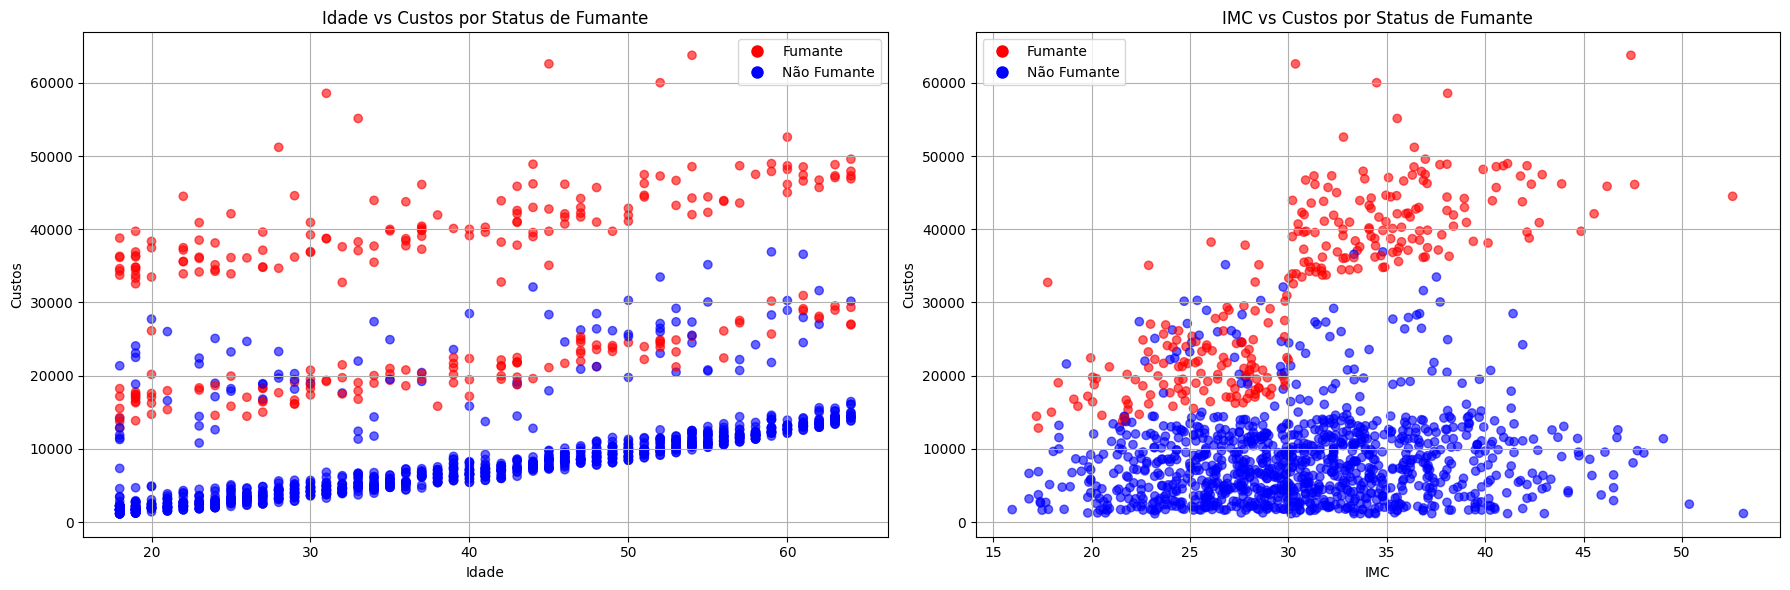

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
colors = df_corr['smoker'].map({0: 'blue', 1: 'red'})

# Age vs Charges, colorido por Smoker
axes[0].scatter(x=df_corr['age'], y=df_corr['charges'], c=colors, alpha=0.6)
axes[0].set_title('Idade vs Custos por Status de Fumante')
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Custos')
axes[0].grid(True)

# BMI vs Charges, colorido por Smoker
axes[1].scatter(x=df_corr['bmi'], y=df_corr['charges'], c=colors, alpha=0.6)
axes[1].set_title('IMC vs Custos por Status de Fumante')
axes[1].set_xlabel('IMC')
axes[1].set_ylabel('Custos')
axes[1].grid(True)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Fumante', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Não Fumante', markerfacecolor='blue', markersize=10)
]
axes[0].legend(handles=legend_elements)
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

Observamos que há 3 faixas bem distintas, claramente existe uma diferenciação de preço pra quem é fumante ou obeso. Os que são fumantes e obesos ao mesmo tempo ficaram acima dos U$30.000, independente da idade!

Existe uma faixa que vai dos 15.000 aos 30.000 que levantou dúvidas. Não foi possível identificar uma relação clara com sexo, região ou número de dependentes. No entanto, a análise sugere que essa faixa intermediária provavelmente corresponde a **não fumantes com outros fatores de risco**, como um IMC elevado, que aumentam seus custos em relação aos não fumantes mais saudáveis.

##### **Análise de Outliers**

Vamos dar uma olhada nos outliers das variáveis numéricas.

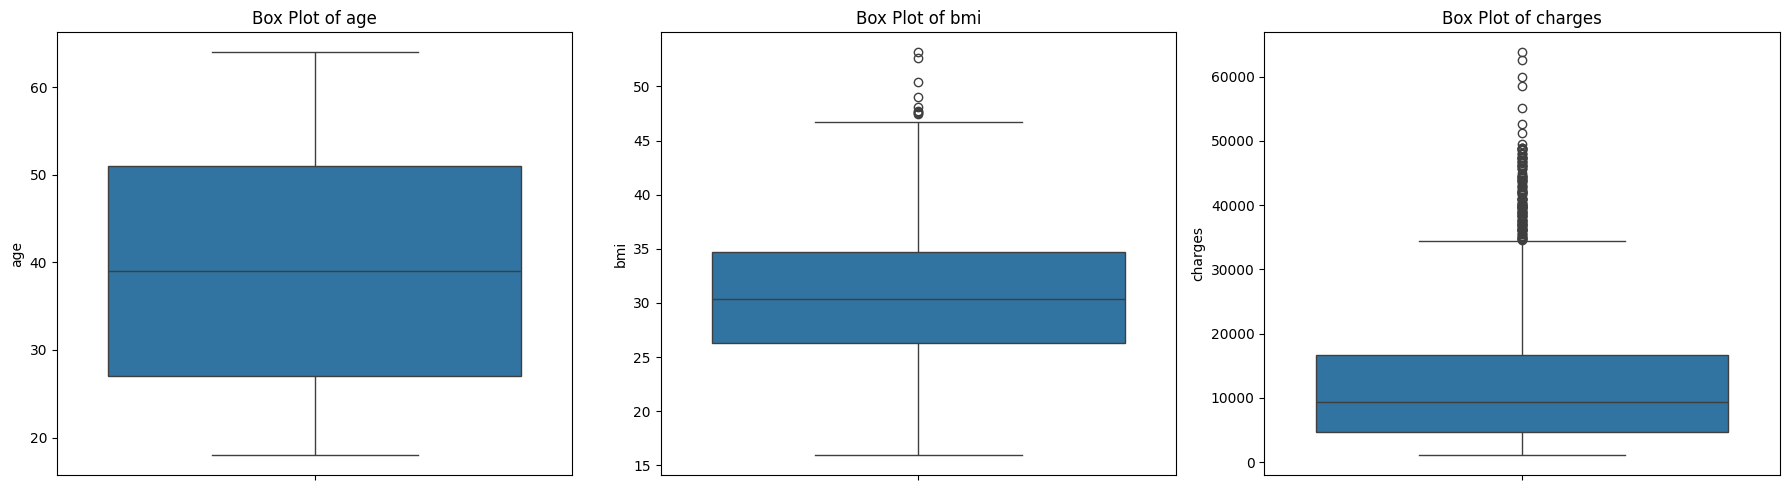

In [176]:
# Box plots para campos numericos
plt.figure(figsize=(18, 5))
for i, col in enumerate(['age', 'bmi', 'charges']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df_insurance[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

O `bmi` e, principalmente, `charges` têm alguns outliers. Isso reforça a decisão de tratar essas variáveis na etapa de pré-processamento.

---

#### **3. Pré-processamento dos Dados**

Nesta fase, preparamos os dados para a modelagem, tratando outliers e transformando as variáveis para um formato adequado.

In [177]:
# 1. Tratamento de Outliers e Assimetria
# Usando Log para normalizar 'charges', que possui forte assimetria
df_insurance['charges'] = np.log1p(df_insurance['charges'])

# Ajustando o 'bmi' no 99º percentil para reduzir o impacto de outliers extremos
bmi_99th = df_insurance['bmi'].quantile(0.99)
df_insurance['bmi'] = np.where(df_insurance['bmi'] > bmi_99th, bmi_99th, df_insurance['bmi'])

# 2. Conversão de Variáveis Categóricas (One-Hot Encoding)
df_encoded = pd.get_dummies(df_insurance, columns=['sex', 'smoker', 'region'], drop_first=True)

print("Dados pré-processados e codificados:")
display(df_encoded.head())

Dados pré-processados e codificados:


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,9.734236,False,True,False,False,True
1,18,33.770,1,7.453882,True,False,False,True,False
2,28,33.000,3,8.400763,True,False,False,True,False
3,33,22.705,0,9.998137,True,False,True,False,False
4,32,28.880,0,8.260455,True,False,True,False,False


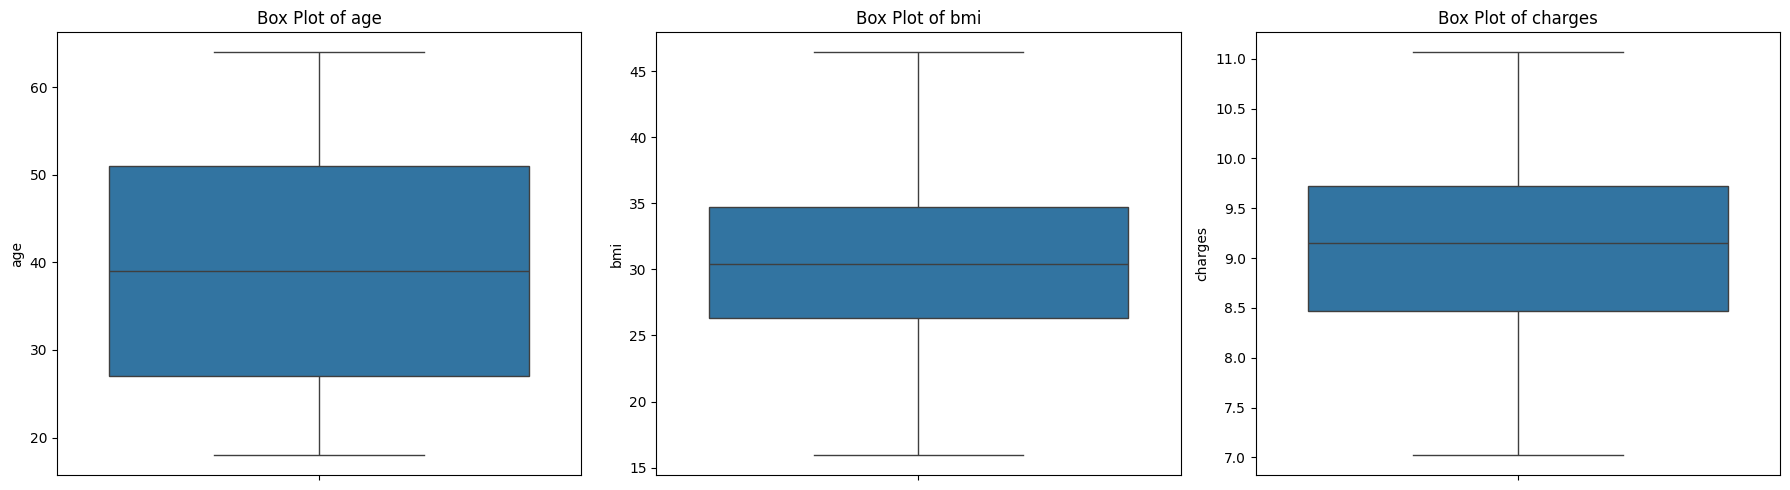

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plots para campos numericos
plt.figure(figsize=(18, 5))
for i, col in enumerate(['age', 'bmi', 'charges']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df_insurance[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

---

#### **4. Separação dos Dados para Modelagem**

Dividimos os dados em conjuntos de treino e teste.

In [179]:
from sklearn.model_selection import train_test_split

# Definindo as variáveis independentes (X) e dependente (y)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Separando os dados, estratificando por 'smoker_yes' para manter a proporção
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['smoker_yes']
)

---

#### **5. Validação Estatística com `statsmodels`**

Esta validação é essencial para entender a significância dos coeficientes de um modelo de regressão linear. Usamos `statsmodels` para obter p-values e avaliar a relevância estatística de cada variável.

**Nota:** Para uma interpretação mais direta dos coeficientes, esta análise é idealmente feita nos dados *antes* da padronização (scaling).

In [180]:
import statsmodels.api as sm

# Para a análise estatística, usamos uma cópia dos dados de treino sem padronização.
# O statsmodels não lida bem com tipos booleanos, então convertemos para inteiros (0 e 1).
X_train_sm = X_train.copy()
for col in X_train_sm.select_dtypes(include=['bool']).columns:
    X_train_sm[col] = X_train_sm[col].astype(int)

# OLS exige a adição manual de uma constante (o intercepto 'b' na equação y = mx + b)
X_train_sm_const = sm.add_constant(X_train_sm)

# Criando e treinando o modelo OLS
model_sm = sm.OLS(y_train, X_train_sm_const).fit()

# Exibindo o resumo completo do modelo
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     425.6
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:27:37   Log-Likelihood:                -655.61
No. Observations:                1070   AIC:                             1329.
Df Residuals:                    1061   BIC:                             1374.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.0791      0.083  

---

#### **6. Preparação para Modelos Preditivos: Padronização**

Agora, padronizamos as features numéricas dos conjuntos de treino e teste para que os modelos preditivos funcionem de forma otimizada.

In [181]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['age', 'bmi', 'children']

# Criar o scaler e treiná-lo APENAS nos dados de treino para evitar data leakage
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# Aplicar a mesma transformação aos dados de teste
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Exemplo de dados de treino após a padronização:")
display(X_train.head())

Exemplo de dados de treino após a padronização:


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
294,-1.007157,-0.660259,1.565207,True,False,False,False,True
179,0.133146,0.403107,1.565207,False,False,False,False,False
1335,-1.506040,1.021382,-0.914712,False,False,False,True,False
634,0.845836,1.498266,-0.088072,True,False,False,False,True
67,0.061877,-0.741413,-0.088072,True,False,True,False,False


---

#### **7. Otimização de Hiperparâmetros**

Usamos o `GridSearchCV` para encontrar os melhores hiperparâmetros para nossos modelos mais complexos.

In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1. Otimização para RandomForest
print("Iniciando otimização para RandomForest...")
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 7, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print(f"Melhores parâmetros para RandomForest: {rf_grid.best_params_}")

# 2. Otimização para Gradient Boosting
print("\nIniciando otimização para Gradient Boosting...")
gb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
print(f"Melhores parâmetros para Gradient Boosting: {gb_grid.best_params_}")

1110631.37s - Error patching args (debugger not attached to subprocess).
Traceback (most recent call last):
  File "/home/pechi/TechChallegeFiap/.venv/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 541, in patch_args
    new_args.append(_get_python_c_args(host, port, code, unquoted_args, SetupHolder.setup))
  File "/home/pechi/TechChallegeFiap/.venv/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 193, in _get_python_c_args
    if "__future__" in code:
TypeError: a bytes-like object is required, not 'str'


Iniciando otimização para RandomForest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros para RandomForest: {'max_depth': 5, 'n_estimators': 100}

Iniciando otimização para Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Melhores parâmetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


---

#### **8. Treinamento e Avaliação Final dos Modelos**

Treinamos o modelo de Regressão Linear e usamos os modelos otimizados para fazer previsões e avaliar o desempenho de cada um.


Métricas de Avaliação dos Modelos:


,R²,RMSE
Random Forest,0.862157,0.345384
Gradient Boosting,0.857274,0.351448
Linear Regression,0.788322,0.428003


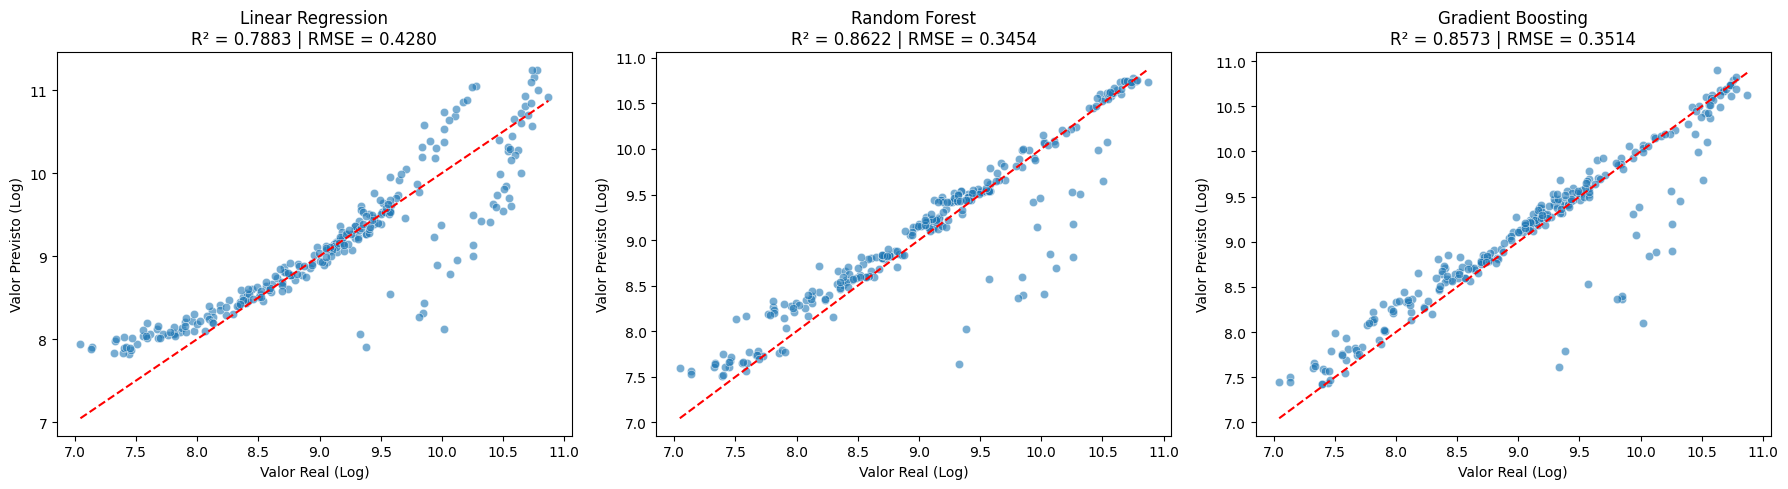

In [183]:
from sklearn.linear_model import LinearRegression

results = {}

# --- Modelo 1: Regressão Linear ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
results['Linear Regression'] = {
    'r2': r2_score(y_test, y_pred_lr),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'y_pred': y_pred_lr
}

# --- Modelo 2: Random Forest (Otimizado) ---
y_pred_rf = best_rf.predict(X_test)
results['Random Forest'] = {
    'r2': r2_score(y_test, y_pred_rf),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'y_pred': y_pred_rf
}

# --- Modelo 3: Gradient Boosting (Otimizado) ---
y_pred_gb = best_gb.predict(X_test)
results['Gradient Boosting'] = {
    'r2': r2_score(y_test, y_pred_gb),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
    'y_pred': y_pred_gb
}

metrics_df = pd.DataFrame({
    'R²': {name: data['r2'] for name, data in results.items()},
    'RMSE': {name: data['rmse'] for name, data in results.items()}
}).sort_values(by='R²', ascending=False)

print("\nMétricas de Avaliação dos Modelos:")
display(metrics_df)

plt.figure(figsize=(18, 5))
for i, (model_name, data) in enumerate(results.items()):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_test, y=data['y_pred'], alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Valor Real (Log)')
    plt.ylabel('Valor Previsto (Log)')
    plt.title(f'{model_name}\nR² = {data["r2"]:.4f} | RMSE = {data["rmse"]:.4f}')
plt.tight_layout()
plt.show()

---

#### **9. Conclusão Final**

Após um ciclo completo de análise, pré-processamento, validação estatística, otimização e avaliação, comparamos o desempenho de três modelos de regressão. As métricas de R² e RMSE foram utilizadas como principais indicadores de performance.

- **Regressão Linear**: Serviu como um bom baseline, mas sua natureza linear limitou sua capacidade de capturar relações complexas nos dados.
- **Gradient Boosting (Otimizado)**: Teve bom desempenho, mas ligeiramente inferior ao Random Forest.
- **Random Forest (Otimizado)**: Apresentou o melhor desempenho geral, com o maior R² e o menor RMSE, sendo o modelo mais recomendado para esta tarefa.

**Observação:** O modelo **Random Forest**, após a otimização de hiperparâmetros, se provou o mais preciso e robusto. Ele consegue generalizar melhor para dados não vistos e capturar as complexas interações entre as variáveis. Portanto, é o modelo recomendado para a tarefa de predição de custos de seguro de saúde.